## The Wonderful World of ML - Session 3 Assignment (Linear Regression)

In addition to the references provided in session 2, I've uploading all the video and course notes from the [**Regression Models**](https://www.coursera.org/learn/regression-models) class from the Johns Hopkins Data Science Specialization on coursera to our meetup repo [here](https://github.com/focods/WonderfulML/tree/master/docs/JHU_DSS_RegMods).  This weeks assignment is adapted from an assignment given in this class.

If you haven't done so by now, install jupyter notebook and configure it with an R kernel if you are an R user.  If you are Python user, your Anaconda install will have Python configured out of the box.  For further details, refer to the top of the session 2 notebooks.

### Only one problem for this session, but it's a good one...

The data for this assignment can be found in our meetup repo:

[https://raw.githubusercontent.com/focods/WonderfulML/master/data/mtcars.csv](https://raw.githubusercontent.com/focods/WonderfulML/master/data/mtcars.csv)

**Here is the scenario:**  *You work for Motor Trend, a magazine about the automobile industry. Looking at a data set of a collection of cars, they are interested in exploring the relationship between a set of variables and miles per gallon (MPG) (outcome). They are particularly interested in the following two questions:*

1. Is an automatic or manual transmission better for MPG?  
2. Quantify the MPG difference between automatic and manual transmissions.

Here is some code to get you started.

In [135]:
mtcars <- read.csv("https://raw.githubusercontent.com/focods/WonderfulML/master/data/mtcars.csv")

head(mtcars)

model,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
Mazda RX4,21.0,6,160,110,3.90,2.620,16.46,0,1,4,4
Mazda RX4 Wag,21.0,6,160,110,3.90,2.875,17.02,0,1,4,4
Datsun 710,22.8,4,108,93,3.85,2.320,18.61,1,1,4,1
Hornet 4 Drive,21.4,6,258,110,3.08,3.215,19.44,1,0,3,1
Hornet Sportabout,18.7,8,360,175,3.15,3.440,17.02,0,0,3,2
Valiant,18.1,6,225,105,2.76,3.460,20.22,1,0,3,1


Let's do a little EDA...

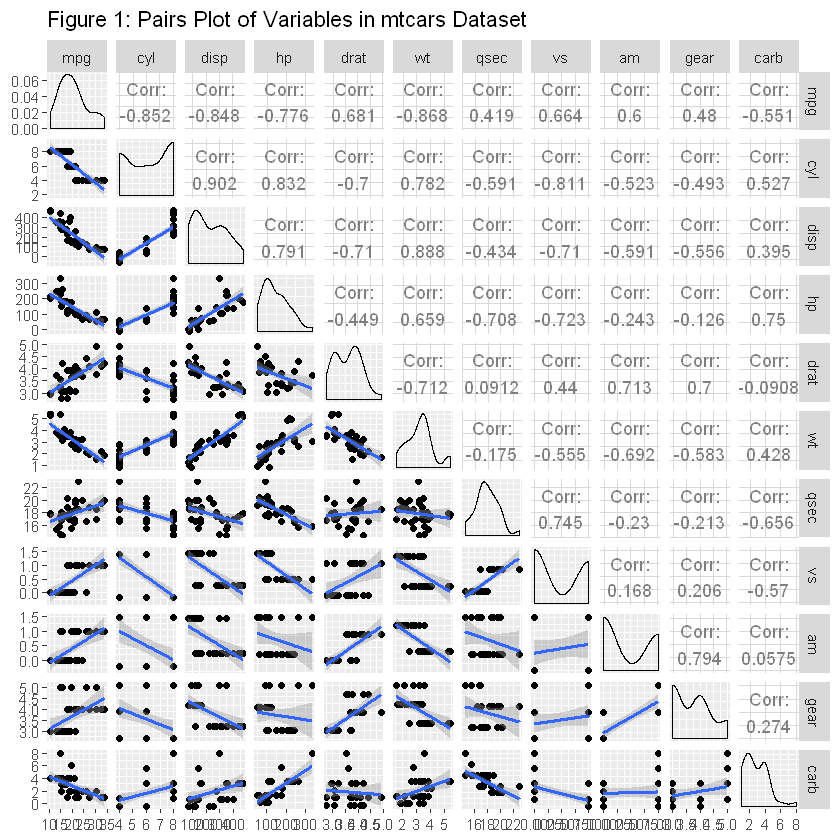

In [136]:
suppressMessages(suppressWarnings(library(dplyr)))
suppressMessages(suppressWarnings(library(bindrcpp)))
suppressMessages(suppressWarnings(library(ggplot2)))
library(dplyr)  # make sure you've done an install.packages so you have these
library(ggplot2)
library(repr)      # need for plot resizing
library(lazyeval)  # need for interp

suppressMessages(suppressWarnings(library(GGally)))
suppressMessages(suppressWarnings(library(ggplot2)))
suppressMessages(suppressWarnings(library(repr)))
library(GGally) #install.packages("GGally")

func <- function(dat=mtcars, mapping, method="loess", ...) {
    p <- ggplot(data = dat, mapping = mapping)
    p <- p + geom_point() + geom_smooth(method=method, ...)
    
    return(p)
}

g <- ggpairs(mtcars[, 2:ncol(mtcars)], lower = list(continuous = wrap(func, method="lm")),
             title = "Figure 1: Pairs Plot of Variables in mtcars Dataset")
# http://blog.revolutionanalytics.com/2015/09/resizing-plots-in-the-r-kernel-for-jupyter-notebooks.html
options(repr.plot.width=7, repr.plot.height=7)
print(g)

Let's take a look at the overall effect of transmission on MPG with this question in mind: *Is an automatic or manual transmission better for MPG?*  

Let's start by taking a look at a box plot comparing all the automatics against all the manual transmissions:

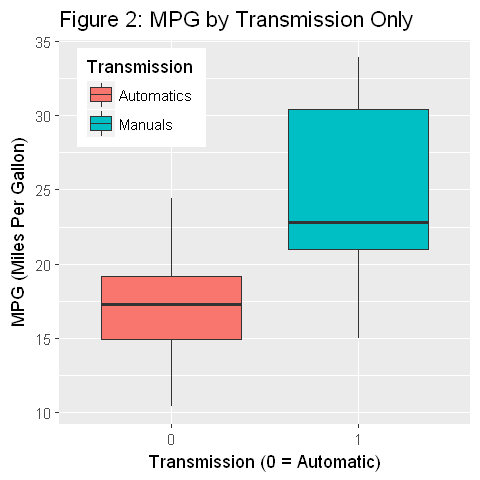

In [137]:
## PlotTools.R contains multiplot function
source('../../R/PlotTools.R')  # running notebook from docs/solutions/ dir under project

## boxplot to compare automatics vs manuals
p1 <- ggplot(mtcars, aes(factor(am), mpg))
p1 <- p1 + ggtitle("Figure 2: MPG by Transmission Only")
p1 <- p1 + geom_boxplot(aes(fill = factor(am)));
p1 <- p1 + scale_fill_discrete(name="Transmission", breaks=c(0,1),
                               labels=c("Automatics", "Manuals"))
p1 <- p1 + theme(legend.position=c(0.2,0.85))
p1 <- p1 + labs(x = "Transmission (0 = Automatic)", y = "MPG (Miles Per Gallon)")

options(repr.plot.width=4, repr.plot.height=4)

p1

The plot suggests that manuals get better mileage than automatics.  Let's see if a t-test confirms this:

In [138]:
t.test(mpg ~ factor(am), paired=FALSE, var.equal=FALSE, data=mtcars)


	Welch Two Sample t-test

data:  mpg by factor(am)
t = -3.7671, df = 18.332, p-value = 0.001374
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -11.280194  -3.209684
sample estimates:
mean in group 0 mean in group 1 
       17.14737        24.39231 


O.k., if we assume that other factors are **not** confounding our results, then the data suggests that manuals provide give better mileage.  So our next task is to check for factors that may be confounding the results keeping in mind that our goal is to create an *appropriate* linear model which focused on the effects of transmission (**am**), **not** to create a model that best predicts MPG from the dataset.

An *appropriate* model for this goal was considered to be one that accurately quantified the effects of transmission on MPG (**mpg**) with only the required number of variables. Based on our initial assumption, the process of model selection should start by first building a simple linear model with **mpg** as the response and **am** as the regressor to use as a *base*:

In [139]:
#mpg_mean <- mean(mtcars$mpg)
#mpg_mean  # 20.09062
f00 <- lm(mpg ~ 1, mtcars); summary(f00)$coef  # reference model: predict w/ mean 20.09062
f01 <- lm(mpg ~ am, mtcars); summary(f01)$coef # base model

,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),20.09062,1.065424,18.85693,1.526151e-18


,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),17.147368,1.124603,15.247492,1.133983e-15
am,7.244939,1.764422,4.106127,2.850207e-04


Since Pr(>|t|) = 2.850207e-04 < 0.05 for **am** in the second table above, we are better than 95% confident that the coefficient (**Estimate** column) is not zero.  Now let's check that we get a signicant drop in RSS by running an ANOVA against the reference and base models.

In [140]:
anova(f00, f01)

Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
31,1126.0472,NA,NA,NA,NA
30,720.8966,1,405.1506,16.86028,0.0002850207


The small value of Pr(>F) (probability that the RSS drop is NOT significant) indicates that the drop in RSS is signicant.

We can now build successive models in a nested fashion by adding variables to the base model, and evaluating each new addition.  As long as the sign on the **am** coefficient doesn't flip, we'll assume that the variable we added is relatively independent from transmission.  If it does flip the sign, then we'll assume there is interacton aka confounding.

If the variable we add can be considered relatively independent of transmission, we'll exclude it from our model.  We'll leave it out of our model because we are only interested in the effect of transmission.  If the variable we add confounds **am**, we'll add an interaction term, check for significance of both the new terms coefficient and the drop in RSS (ANOVA).

In [141]:
# Add weight
f02 <- lm(mpg ~ am + wt, mtcars); summary(f02)$coef

,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),37.32155131,3.0546385,12.21799285,5.843477e-13
am,-0.02361522,1.5456453,-0.01527855,9.879146e-01
wt,-5.35281145,0.7882438,-6.79080719,1.867415e-07


Transmission flips sign indicating interaction. Signficance of transmission falls substantially when we add weight.  Let's add an interaction term:

In [142]:
f03 <- lm(mpg ~ am + wt + am*wt, mtcars); summary(f03)$coef
f03$coefficients['am:wt']

,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),31.416055,3.0201093,10.402291,4.001043e-11
am,14.878423,4.2640422,3.489277,1.621034e-03
wt,-3.785908,0.7856478,-4.818836,4.551182e-05
am:wt,-5.298360,1.4446993,-3.667449,1.017148e-03


am:wt 
-5.29836

The **am:wt** is significant, so let's look at the ANOVA:

In [143]:
anova(f02, f03)

Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
29,278.3197,NA,NA,NA,NA
28,188.0077,1,90.31203,13.45018,0.001017148


Adding **am*wt** interaction term improves mpg prediction (drop in RSS is significant).  Let's see what happens when we add number of cyliders to the model:

In [144]:
f04 <- lm(mpg ~ am + wt + am*wt + as.numeric(cyl), mtcars); summary(f04)$coef

,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),34.282998,2.7964507,12.259468,1.518742e-12
am,11.938516,3.8453256,3.104683,4.438319e-03
wt,-2.368930,0.8243992,-2.873523,7.815636e-03
as.numeric(cyl),-1.181366,0.3802985,-3.106417,4.419268e-03
am:wt,-4.197434,1.3115498,-3.200362,3.496375e-03


Adding **cyl** had a non-zero coefficient, but does not flip the sign so we'll leave it out of our model.  Let's try adding displacement: **disp**

In [145]:
f05 <- lm(mpg ~ am + wt + am*wt  + disp, mtcars); summary(f05)$coef;

,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),28.83107265,3.026192252,9.527178,3.972078e-10
am,15.01016801,3.969248403,3.781615,7.863922e-04
wt,-1.74591925,1.147584061,-1.521387,1.397891e-01
disp,-0.01757537,0.007619728,-2.306562,2.898694e-02
am:wt,-5.27453954,1.344720670,-3.922405,5.432238e-04


Same drill: displacement has a significant (non-zero) coefficient, but it doesn't flip the sign of **am**, so we'll exclude this on also.  This is what adding the rest of the variables looks like:

In [146]:
f06 <- lm(mpg ~ am + wt + am*wt + hp, mtcars); summary(f06)$coef;
f07 <- lm(mpg ~ am + wt + am*wt + drat, mtcars); summary(f07)$coef;
f08 <- lm(mpg ~ am + wt + am*wt + qsec, mtcars); summary(f08)$coef;
# https://stackoverflow.com/questions/18617174/r-mtcars-dataset-meaning-of-vs-variable
f09 <- lm(mpg ~ am + wt + am*wt + vs, mtcars); summary(f09)$coef;
f10 <- lm(mpg ~ am + wt + am*wt + gear, mtcars); summary(f10)$coef;
f11 <- lm(mpg ~ am + wt + am*wt + carb, mtcars); summary(f11)$coef;

,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),30.94733319,2.723410935,11.363446,8.546944e-12
am,11.55481296,4.023276579,2.871991,7.844579e-03
wt,-2.51558550,0.844496532,-2.978799,6.051842e-03
hp,-0.02694935,0.009795903,-2.751084,1.047673e-02
am:wt,-3.57790980,1.442795585,-2.479845,1.967639e-02


,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),25.935401,6.3627802,4.0761114,0.0003617524
am,13.914881,4.3793004,3.1774209,0.0037029803
wt,-3.511890,0.8345861,-4.2079419,0.0002547873
drat,1.353464,1.3827219,0.9788405,0.3363485410
am:wt,-5.173097,1.4514333,-3.5641302,0.0013846386


,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),9.723053,5.8990407,1.648243,0.1108925394
am,14.079428,3.4352512,4.098515,0.0003408693
wt,-2.936531,0.6660253,-4.409038,0.0001488947
qsec,1.016974,0.2520152,4.035366,0.0004030165
am:wt,-4.141376,1.1968119,-3.460340,0.0018085763


,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),26.253922,3.345821,7.846781,1.948737e-08
am,14.320385,3.865840,3.704339,9.623044e-04
wt,-2.702632,0.818323,-3.302646,2.702549e-03
vs,2.929749,1.094536,2.676703,1.248696e-02
am:wt,-4.663422,1.329216,-3.508401,1.598571e-03


,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),28.9678830,5.2367676,5.5316343,7.328471e-06
am,14.9124752,4.3162787,3.4549380,1.833792e-03
wt,-3.6775362,0.8171697,-4.5003336,1.165851e-04
gear,0.6353264,1.1034411,0.5757683,5.695402e-01
am:wt,-5.5608348,1.5316725,-3.6305639,1.165843e-03


,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),30.883322,2.9719653,10.391549,6.188907e-11
am,13.014478,4.3428565,2.996755,5.791591e-03
wt,-3.178149,0.8652286,-3.673189,1.043619e-03
carb,-0.642290,0.4216379,-1.523321,1.393063e-01
am:wt,-4.133352,1.6056300,-2.574287,1.584898e-02


The sign on the **am**, **wt** and **am:wt** remained the same and magnitudes didn't change much either, so **f03** is reasonable choice to quantify the effect of transmission.  But how do we deal with this confounding with weight?  At this point, we should take a look at a plot of **mpg** vs. **wt** by cylinders and transmission types and mark out the weight zone where transmission types overlap:

Warning message:
"Removed 37 rows containing missing values (geom_path)."

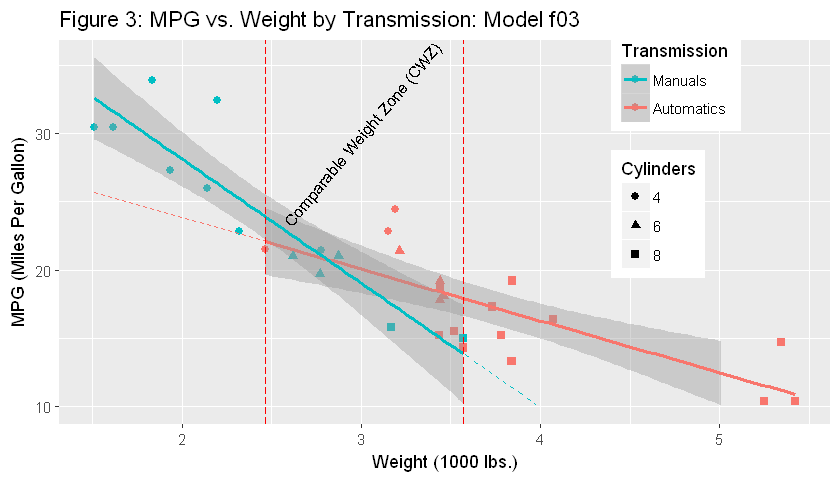

In [147]:
# create model functions to overlay data
f03_fun <- function(fit=f03, am_var, wt_var) {
    y <- f03$coefficients['(Intercept)'] +
         (f03$coefficients['am'] * am_var) +
         (f03$coefficients['wt'] * wt_var) +
         (f03$coefficients['am:wt'] * am_var * wt_var)
    
    return(y)
}

mpg_fun_auto <- function(wgt) { return(f03_fun(f03, 0, wgt)) }
mpg_fun_manu <- function(wgt) { return(f03_fun(f03, 1, wgt)) }

# find comparable weight zone (CWZ): overlapping weight range
overlap.low.bound <- min(filter(mtcars, am == 0)$wt) # lightest automatic
overlap.upp.bound <- max(filter(mtcars, am == 1)$wt) # heaviest manual

p3 <- ggplot(mtcars, aes(x = wt, y = mpg, color=factor(am)))
p3 <- p3 + ggtitle("Figure 3: MPG vs. Weight by Transmission: Model f03")
p3 <- p3 + geom_point(aes(shape=factor(cyl)), size = 2)
p3 <- p3 + stat_function(fun = mpg_fun_auto, colour = "#F8766D", linetype = 2)
p3 <- p3 + stat_function(fun = mpg_fun_manu, colour = "#00BFC4", linetype = 2)
p3 <- p3 + geom_smooth(method = "lm")
p3 <- p3 + geom_vline(xintercept = c(overlap.low.bound, overlap.upp.bound),
                      colour="red", linetype = "longdash")
p3 <- p3 + annotate("text", x = 3, y = 30, color = "black", angle = 50,
                     label = "Comparable Weight Zone (CWZ)", size=3.4)
p3 <- p3 + labs(x = "Weight (1000 lbs.)", y = "MPG (Miles Per Gallon)")
p3 <- p3 + scale_y_continuous(limits = c(10, NA))
p3 <- p3 + scale_color_discrete(name=c("Transmission"), breaks=c(1,0),
                               labels=c("Manuals","Automatics"))
p3 <- p3 + scale_shape_discrete(name=c("Cylinders"))
p3 <- p3 + theme(legend.position=c(0.8,0.7))
options(repr.plot.width=7, repr.plot.height=4)
p3

If the slopes in the CWZ are not statistically different, then we can't claim a significant effect by transmission.  Let's write a function that tests these slopes.

In [148]:
## Returns the p-value that the slope d(mpg)/d(add_param) is NOT significantly different
## between values of base_compare: am = manual = 1 vs. am = automatic = 0
## data - dataframe containing the data
## model_fun - string representation of linear model formula (e.g. y ~ x),
##             default: f03 formula string
## base_compare - predictor which we are comparing slopes against: am in this analysis
## add_param - last predictor being added to the linear model
testSlopes <- function(data=mtcars, model_fun="mpg ~ am + wt + am*wt", 
                       base_compare="am", add_param="wt") {
    df.manual <- data %>% filter_(interp(~v == 1, v = as.name(base_compare)))
    df.autom <- data %>% filter_(interp(~v == 0, v = as.name(base_compare)))
    
    fit.manual <- lm(as.formula(model_fun), data=df.manual)
    fit.autom <- lm(as.formula(model_fun), data=df.autom)
    beta1.hat.manual <- summary(fit.manual)$coef[2, 1]  # -9.084268
    beta1.hat.autom <- summary(fit.autom)$coef[2, 1]    # -3.785908
    
    
    sigma.manual <- summary(fit.manual)$sigma
    sigma.autom <- summary(fit.autom)$sigma
    sigma.beta1.manual <- sigma.manual / sqrt(sum((df.manual[[add_param]] -
                                                   mean(df.manual[[add_param]]))^2))
    sigma.beta1.autom <- sigma.autom / sqrt(sum((df.autom[[add_param]] -
                                                 mean(df.autom[[add_param]]))^2))
    # confidence interval specifics:
    t.crit.manual <- qt(0.975, length(df.manual[[base_compare]]) - 2)  # 2.200985
    t.crit.autom <- qt(0.975, length(df.autom[[base_compare]]) - 2)  # 2.109816
    beta1.int.manual <- beta1.hat.manual + c(-1,1) * t.crit.manual * sigma.beta1.manual
    beta1.int.autom <- beta1.hat.autom + c(-1,1) * t.crit.autom * sigma.beta1.autom
    
    # t-test specifics:
    n.manual <- nrow(df.manual)
    n.autom <- nrow(df.autom)
    dof <- n.manual + n.autom - 2
    s_pooled <- sqrt((((n.manual-1)*sigma.beta1.manual^2) +
                          ((n.autom-1)*sigma.beta1.autom^2)) / dof) # 0.99205
    t_stat <- (beta1.hat.manual - beta1.hat.autom) *
              (1/n.manual + 1/n.autom)^0.5 / s_pooled  # -1.92236629
    p_val <- pt(t_stat, dof, lower.tail=TRUE) # 0.0321 consistent w/conf int's: SIG
    
    return(list(p_val, beta1.int.manual, beta1.int.autom))
}

testSlopes()[[1]] # p-value
testSlopes()[[2]] # manual slope 95% confidence interval
testSlopes()[[3]] # automatic slope 95% confidence interval

[1] 0.03205041

[1] -11.84997  -6.31857

[1] -5.403201 -2.168614

### Conclusions

We can see that these slope are significantly different by the p-value < 0.05 and by the fact that the 95% confidence intervals don't overlap.

We can answer our first question by looking at Figure 3 and values in the previous cell.  As mentioned earlier, the transmission and weight have a strong interaction in modeling **mpg**.  Manuals do better than automatic below about 2800 lbs.  From about 2800 lbs. to a little over 3500 lbs. (heaviest manual), automatics tend to do better as weight increases.  Outside the CWZ, we can't draw any reasonable conclusions from the data for two reasons.  First, above the the CWZ, we only have data for 8 cylinder automatics.  Second, below the CWZ, wee only data for 4 cylinder manuals.

Wrt to our second question, we have quantifed the difference in **mpg** in a linear function of weight and transmission of the form:

$$
    m = 31.416055 + (14.878423)t - (3.785908)w - (5.298360)tw
$$

where m = mileage in miles per gallon, t = transmission, a binary variable which is 0 if automatic or 1 if manual, and w = weight in 1000 lbs.

The drop off in **mpg** is steeper for manuals ranging from -11.85 to -6.32 mpg per 1000 lb. weight increase.  For automatics, the drop in **mpg** ranges from -5.40 to -2.17 mpg per 1000 lbs..  Both of these ranges were constructed at the 95% confidence level ($\alpha = 0.05$)  

$$\newcommand{\xv}{\mathbf{x}}
\newcommand{\Xv}{\mathbf{X}}
\newcommand{\yv}{\mathbf{y}}
\newcommand{\Yv}{\mathbf{Y}}
\newcommand{\zv}{\mathbf{z}}
\newcommand{\av}{\mathbf{a}}
\newcommand{\Wv}{\mathbf{W}}
\newcommand{\wv}{\mathbf{w}}
\newcommand{\betav}{\mathbf{\beta}}
\newcommand{\gv}{\mathbf{g}}
\newcommand{\Hv}{\mathbf{H}}
\newcommand{\dv}{\mathbf{d}}
\newcommand{\Vv}{\mathbf{V}}
\newcommand{\vv}{\mathbf{v}}
\newcommand{\tv}{\mathbf{t}}
\newcommand{\Tv}{\mathbf{T}}
\newcommand{\Sv}{\mathbf{S}}
\newcommand{\zv}{\mathbf{z}}
\newcommand{\Zv}{\mathbf{Z}}
\newcommand{\Norm}{\mathcal{N}}
\newcommand{\muv}{\boldsymbol{\mu}}
\newcommand{\sigmav}{\boldsymbol{\sigma}}
\newcommand{\phiv}{\boldsymbol{\phi}}
\newcommand{\Phiv}{\boldsymbol{\Phi}}
\newcommand{\Sigmav}{\boldsymbol{\Sigma}}
\newcommand{\Lambdav}{\boldsymbol{\Lambda}}
\newcommand{\half}{\frac{1}{2}}
\newcommand{\argmax}[1]{\underset{#1}{\operatorname{argmax}}}
\newcommand{\argmin}[1]{\underset{#1}{\operatorname{argmin}}}
\newcommand{\dimensionbar}[1]{\underset{#1}{\operatorname{|}}}
\newcommand{\dimensionbar}[1]{\underset{#1}{\operatorname{|}}}
\newcommand{\grad}{\mathbf{\nabla}}
\newcommand{\ebx}[1]{e^{\wv_{#1}^T \xv_n}}
\newcommand{\eby}[1]{e^{y_{n,#1}}}
\newcommand{\Tiv}{\mathbf{Ti}}
\newcommand{\Fv}{\mathbf{F}}
\newcommand{\ones}[1]{\mathbf{1}_{#1}}
$$

## The Wonderful World of ML - Session 3 Discussion: Logistic Regression

<img src="https://raw.githubusercontent.com/MichaelSzczepaniak/WonderfulML/master/docs/graphics/child_on_logistic_curve_70per.jpg">

Logistic regression provides a straightforward way to model the probability that one of two mutually exclusive outcomes will occur. This is another way of saying that this is a technique used for **binary classification**. Because this is one of the simplest and most popular classifiers out there, this should be in every machine learning practicioners toolbox.  It also serves as a good starting point for more sophisticated classification techniques such as LDA and QDA which we'll cover in the next session.

What are some examples of binary classification?
+ Will a team win or loss a game?
+ Will a customer buy or not buy?
+ Will a person survive 90 days after a myocardial infarction (heart attack)?
+ Will a passenger survive the Titanic disaster? (kaggle competition)

### What is logistic regression modeling?

At first look, it may seem odd to call this classifier logistic *regression* until you realize that this technique is modeling the underlying conditional probability of an event occuring given one or more predictors.  In other words, we are fitting a function to $p(C=k\,|\, \xv_n)$ where $C=\text{class of } n^\text{th}\text{ sample}$ which is binary,  meaning that k can only be 0 or 1.  The term $\xv_n$ is a vector of predictors for the $n^{th}$ sample.

### How is this model constructed?

A natural way to think about modeling a probablity is to divide the count of an event by the total number of events.  Let's start by proposing a function $f(\xv;\wv_k)$ that is proportional to the count or frequency of a given event $k$.  With our $f(\xv;\wv_k)$ as a function of our predictors $\xv$ and some weight parameters $\wv_k$ for each class, we can use this to compute probabilities by dividing $f(\xv;\wv_k)$ for a particular class $k$ by the total count in all classes which can be expressed as:

1.$$
    \begin{align*}
      p(C=k|\xv) = \frac{f(\xv;\wv_k)}{\sum_{m=1}^K f(\xv;\wv_m)} = g_k(\xv)
    \end{align*}
$$

The above ensures that $p(C=k|\xv)$ will be between 0 and 1 if $f(\xv;\wv_k) \gt 0$, but we have another contraint which is:

2.$$
      \begin{align*}
      1  = \sum_{k=1}^K p_k(C=k|\xv) = \sum_{k=1}^K g_k(\xv)
      \end{align*}
$$

If we look closely at this equation 2., we notice that this really gives us only $(k-1)$ contraints on $g_k(\xv)$ because we can always determine one these contraints by subtracting 1 from the sum of the other.  In other words, for some arbitrary $g_m(\xv)$ where $m \ne k$, we can write:

3.$$
      \begin{align*}
      g_m(\xv) = 1 - \sum_{k=1, k \ne m}^K g_k(\xv)
      \end{align*}
$$

So, we'll just set the final $f(\xv;\wv_k)$, for $k=K$, to be 1.  This gives us:

4.$$
      \begin{align*}
        g_k(\xv) = \left \{ \begin{array}{ll}
            \dfrac{f(\xv;\wv_k)}{1+\sum_{m=1}^{K-1} f(\xv;\wv_m)}, & k < K\\
            \dfrac{1}{1+\sum_{m=1}^{K-1} f(\xv;\wv_m)}, & k = K
          \end{array}
        \right .
      \end{align*}
$$

Since we are only considering two classes, we can drop the subscript $k$ and write:

5.$$
      \begin{align*}
        g(\xv) = \dfrac{f(\xv;\wv)}{1+f(\xv;\wv)}
      \end{align*}
$$

So how do we select $f(\xv;\wv)$?  As it turns out, selecting $f(\xv;\wv) = e^{\wv^T \xv}$ allows us to more easily evaluate the gradient of the log-likelihood function which is used to find the best fit parameters which we'll touch on in the next section below.  For now, we'll just point out that selecting our $f(\xv;\wv)$ in this way results in the *logisitic function* shown in equation (4.2) in the ISL and more generally below:

6.$$
      \begin{align*}
        g(\xv) = \dfrac{e^{\wv^T \xv}}{1+e^{\wv^T \xv}} = p(C=k|\xv)
      \end{align*}
$$

If you play with 6. a little, you can easily convince yourself that this is the same function as $sigmoid(x) = \dfrac{1}{1+e^{-\wv^T \xv}}$.  Leaving 6. in the form of the logistic function allows us to more easily see that with a little manipulation, we can rewrite 6. in terms of the *odds* or *odds ration* as:

7.$$
      \begin{align*}
        \frac{p(C=k|\xv)}{1 - p(C=k|\xv)} = e^{\wv^T \xv} = \text{odds or odds ratio}
      \end{align*}
$$

If we take the natural log of both sides of 7., we get a more general form of what is shown as equation (4.4) in the ISL.

8.$$
      \begin{align*}
        \ln{\Big(\frac{p(C=k|\xv)}{1 - p(C=k|\xv)}\Big)} = \wv^T \xv
      \end{align*}
$$

The left side of 8. is referred to as the *log-odds* or *logit* and we can see clearly that the model assumes that this quantity is linear in the predictors $\xv$.

### How do we find the best parameters for the model?

The most common way to solve for our parameters is to *maximize the likelihood* of our model fit to the data.  *What is the likelihood?*  The likelihood is just the product of all $p(C=\text{class of }
n^\text{th}\text{ sample}\,|\,\xv_n)$ values for sample $n$.  A common way to express this product is

9.$$
    \begin{align*}
      L(\wv) = \prod_{n=1}^N \prod_{k=1}^K p(C=k\,|\, \xv_n)^{t_{n,k}}
    \end{align*}
$$


What's that $t_{n,k}$ term in 9. mean?  This is referred to as a *binary indicator variable* which can only take on the values of 1 or 0. $t_{n,k}$ is 1 when $k$ is the correct (target) class and 0 at all other values of $k$.  For example, say we have three classes ($K=3$) and training sample $n$ is from Class 2, then the  product is

$$
      \begin{align*}
        p(C=1\,|\,\xv_n)^{t_{n,1}} p(C=2\,|\,\xv_n)^{t_{n,2}}
        p(C=3\,|\,\xv_n)^{t_{n,3}} & = 
         p(C=1\,|\,\xv_n)^0 p(C=2\,|\,\xv_n)^1 p(C=3\,|\,\xv_n)^0 \\
        & = 1\; p(C=2\,|\,\xv_n)^1 \; 1 \\
        & = p(C=2\,|\,\xv_n) 
      \end{align*}
$$

This shows how the indicator variables as exponents select the correct terms to be included in the product.

Now that we know what our object function is, we can turn our attention to finding $\wv$ that maximizes the data likelihood.  How should we proceed?

Right.  Find the derivative of 9. with respect to each component of $\wv$, or the gradient with respect to $\wv$.  But there is a mess of products in this. So let's make this easier by working with the natural logarithm  $\ln\Big( L(\wv)\Big)$ which we will call $LL(\wv)$.

10.$$
    \begin{align*}
      LL(\wv) = \ln\Big( L(\wv) \Big) = \sum_{n=1}^N \sum_{k=1}^K t_{n,k}  \log p(C=k\,|\,\xv_n)
    \end{align*}
$$

Since $LL(\wv)$ is not linear in $\wv$, we need to solve 10. iteratively using gradient **ascent**, that is stepping up the gradient because we are **maximizing** our log-likelihood objective function as opposed to minimizing a *cost* function like we did for linear regression.

The procedure is

  * Initialize $\wv$ to some value.
  * Make small change to $\wv$ in the direction of the  gradient of $LL(\wv)$ with respect to $\wv$  (or $\grad_{\wv} LL(\wv)$)
  * Repeat above step until $LL(\wv)$ seems to be at a maximum.

$$
      \begin{align*}
        \wv \leftarrow \wv + \alpha \grad_{\wv} LL(\wv)
      \end{align*}
$$

where $\alpha$ is a constant that affects the step size.

Deriving the expression for the gradient and the details regarding the update rules gets a bit involved, so for those that are interested, I describe these details in [this notebook (not available yet...)]().

### What tools are available in R to do logistic regression?

In R, the **glm** function is the most commonly used.

### How do we handle discrete and continuous variables in our model?

This is best shown with an example.  Let's say we want to model how the Broncos did in their 2016 season.  We can use logistic regression to estimate the probability that the Broncos win as a function of whether they played their game at home or away (discrete) and as function of their final score (not strictly continuous, o.k. for our example).  Since this dataset is so small, we'll train on all the data which we wouldn't want to do in practice.

In [149]:
data_path <- "https://raw.githubusercontent.com/MichaelSzczepaniak/WonderfulML/master/data/broncos2016.csv"
broncos_data <- read.csv(data_path)
head(broncos_data)

Date,Week,DenScore,OppScore,DenWin,Home,Notes
09/08/2016,1,21,20,1,1,
09/18/2016,2,34,20,1,1,
09/25/2016,3,29,17,1,0,
10/02/2016,4,27,7,1,0,
10/09/2016,5,16,23,0,1,
10/13/2016,6,13,21,0,0,


In [150]:
logRegBroncos <- glm(broncos_data$DenWin ~ broncos_data$DenScore, family="binomial")
summary(logRegBroncos)


Call:
glm(formula = broncos_data$DenWin ~ broncos_data$DenScore, family = "binomial")

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.1947  -0.2699   0.2206   0.4761   1.2306  

Coefficients:
                      Estimate Std. Error z value Pr(>|z|)  
(Intercept)            -7.0906     3.7653  -1.883   0.0597 .
broncos_data$DenScore   0.3483     0.1702   2.047   0.0407 *
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 21.930  on 15  degrees of freedom
Residual deviance: 10.965  on 14  degrees of freedom
AIC: 14.965

Number of Fisher Scoring iterations: 6


In [151]:
logRegBroncos$coefficients[1]
logRegBroncos$coefficients[2]

(Intercept) 
  -7.090561

broncos_data$DenScore 
            0.3483174

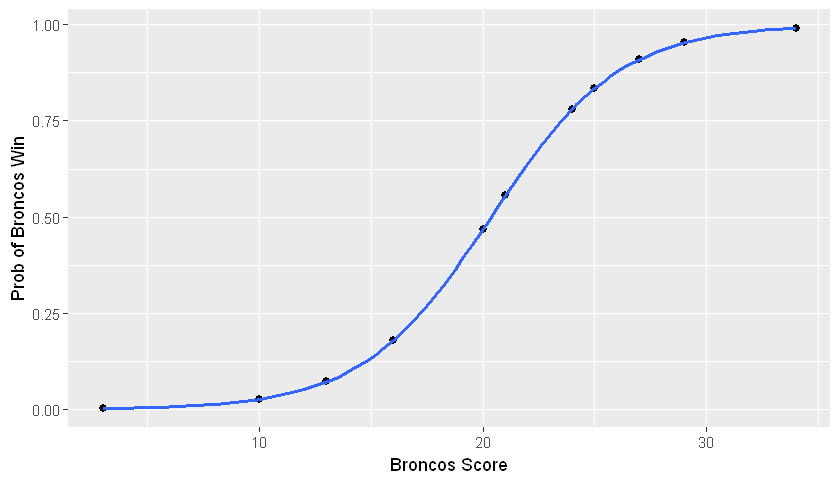

In [152]:
suppressMessages(suppressWarnings(library(dplyr)))
suppressMessages(suppressWarnings(library(ggplot2)))
library(ggplot2)

logOddsInter <- logRegBroncos$coefficients[1]
logOddsSlope <- logRegBroncos$coefficients[2]

p <- ggplot(broncos_data, aes(x=DenScore, y=logRegBroncos$fitted))
p <- p + geom_point(size=2) + stat_smooth(method="lm",
                                          formula = y ~ I(1 / (1 + exp((-logOddsSlope*x) - logOddsInter))))
p <- p + labs(x="Broncos Score", y="Prob of Broncos Win")
print(p)

Now let's take a look at the **Home vs. Away** variable.  Before doing this, let's take a look at the Broncos home record:

In [153]:
home_wins <- sum(broncos_data$DenWin[broncos_data$Home == 1])
home_games <- length(broncos_data$Home[broncos_data$Home == 1])
home_wins/home_games

[1] 0.625

This suggests that playing at home may offer a small advantage, but we need to be careful assuming this because score may be confounding the result.  With this in mind, let's add it to the model and see what happens.

In [154]:
logRegBroncos2 <- glm(broncos_data$DenWin ~ broncos_data$DenScore + broncos_data$Home, family="binomial")
summary(logRegBroncos2)


Call:
glm(formula = broncos_data$DenWin ~ broncos_data$DenScore + broncos_data$Home, 
    family = "binomial")

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.1067  -0.2845   0.1932   0.4868   1.2189  

Coefficients:
                      Estimate Std. Error z value Pr(>|z|)  
(Intercept)            -7.1878     3.8402  -1.872   0.0612 .
broncos_data$DenScore   0.3668     0.1826   2.009   0.0445 *
broncos_data$Home      -0.6129     1.6402  -0.374   0.7086  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 21.93  on 15  degrees of freedom
Residual deviance: 10.82  on 13  degrees of freedom
AIC: 16.82

Number of Fisher Scoring iterations: 6


Adding the **Home** variable wasn't significant (huge p-value), so leaving it out of the model would make sense